In [1]:
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import skimage.io as io
import seaborn as sns; sns.set_context("talk")
font = {'size'   : 16, 'weight' : 'normal', 'family' : 'arial'}
matplotlib.rc('font', **font)

def xlsx2D_to_df1D(xlsx_path, sheet, data_col):
    df = pd.read_excel(xlsx_path, sheet_name=sheet, index_col=0)
    df = df.unstack().reset_index(name=data_col) # unpivot (linearize) the table
    df.rename(columns={'level_1': 'antigen_row', 'level_0': 'antigen_col'}, inplace=True)
    df = df[['antigen_row', 'antigen_col', data_col]]
    return df
    

# Setup

*  xkappa biotin spots: these spots are coated with human kappa light chain conjugated to biotin, so that when the streptavidin-HRP is added there is strong signal independent of the serum content.  **We should not expect the fiducial signal to weaken with serial dilution.**
*  Row-5 (row index 4) in multiple wells shows excessive comets and are not interpretable. The row corresponds to concentration range of (SARS-CoV2-RBD).  
*  Looking at debug plots, following spots are not reliable:
 * A1: row-4, (5,1)
 * B1: row-4, (5,1)
 * C3: whole well
 * D3: whole well
 * E3: whole well
 * E11: whole well


## Set paths

In [13]:
data_folder=r'/Volumes/GoogleDrive/My Drive/ELISAarrayReader/images_scienion/2020-04-08-14-48-49-COVID_concentrationtest_April8_images'
plateinfo_path=os.path.join(data_folder,'COVIDplateinfo0408.csv')
antigenOD_path=os.path.join(data_folder,'python_median_ODs.xlsx') 
python_int_path=os.path.join(data_folder,'python_median_intensities.xlsx') 
python_bg_path=os.path.join(data_folder,'python_median_backgrounds.xlsx')
antigens_path=os.path.join(data_folder,'python_antigens.xlsx')
scienionpath=os.path.join(data_folder,'2020-04-08-14-57-09-COVID_concentrationtest_April8_analysis2.xlsx')


# Read antigen and plate info

In [9]:
plate_info_df=pd.read_csv(plateinfo_path)
plate_info_df.rename(columns={'Well': 'well_id', 'Type':'type', 'Dilution':'dilution'}, inplace=True)

#serum_day_df=plate_info_df['Sera ID'].str.split('-Day', expand=True) #If sera names are not organized by ID+collection day, comment out
#serum_day_df.fillna(0, inplace=True)
#serum_day_df.columns=['serum', 'day']
#serum_day_df['day'] = serum_day_df['day'].astype(int)
#plate_info_df = pd.concat([plate_info_df, serum_day_df], axis=1)
#plate_info_df.drop(['Sera ID'], axis=1, inplace=True)

print(plate_info_df[plate_info_df['Sera ID']=='pos 1']['dilution'].unique())
plate_info_df

[2.00000e-02 5.00000e-03 1.25000e-03 3.12500e-03 7.81250e-05 1.95313e-05
 4.88281e-06 1.22070e-06]


,well_id,Sera ID,type,dilution
0,A1,pos 1,Control,0.020000
1,A2,pos 2,Control,0.020000
2,A3,pos 3,Control,0.020000
3,A4,pos 4,Control,0.020000
4,A5,neg 1,Control,0.020000
...,...,...,...,...
91,H8,neg 12,Control,0.000039
92,H9,neg 13,Control,0.000039
93,H10,neg 14,Control,0.000039
94,H11,neg 15,Control,0.000039


In [4]:
antigen_df = xlsx2D_to_df1D(xlsx_path=antigens_path, sheet='antigens', data_col='antigen')   
antigen_df

,antigen_row,antigen_col,antigen
0,0,0,xkappa-biotin
1,1,0,xkappa-biotin
2,2,0,xIgG Fc
3,3,0,xIgG Fc
4,4,0,GFP foldon
5,5,0,xkappa-biotin
6,0,1,HA H1 MI
7,1,1,MERS RBD-500
8,2,1,SARS RBD-500
9,3,1,SARS CoV2 RBD-80


# Read analysis output from Scienion 

In [53]:
# Read all wells into dictionary. 
scienion_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = pd.read_excel(scienionpath, sheet_name=well_id)
    OD_1_well_df['well_id'] = well_id
    scienion_df = scienion_df.append(OD_1_well_df, ignore_index=True)

scienion_df[0:20]
# scienion_df.shape

,ID,X [µm],Y [µm],Result,"Intensity (median, background corrected) [AU]",Analyte level (median) [U/ml],Diameter [µm],Area [µm²],Saturation,Mean,Median,StdDev,Min,Max,Background Mean,Background Median,Background StdDev,Background Min,Background Max,well_id
0,spot-1-2,2851.0,4002.0,Positive,51.841,NaN,159.0,19884.0,0.0,131.123,134.597,14.249,92.045,158.345,85.759,82.756,7.411,77.547,120.599,A1
1,spot-1-3,3237.0,3978.0,Positive,52.960,NaN,174.0,23647.0,0.0,132.582,135.677,13.112,96.388,157.991,85.327,82.717,7.095,76.596,120.873,A1
2,spot-1-4,3622.0,3975.0,Positive,47.950,NaN,184.0,26531.0,0.0,127.449,130.359,12.474,90.242,152.734,85.361,82.410,7.797,75.833,124.732,A1
3,spot-1-5,4057.0,4000.0,Positive,48.531,NaN,159.0,19799.0,0.0,124.422,128.668,13.636,89.092,146.738,82.154,80.137,6.251,74.815,117.292,A1
4,spot-2-2,2861.0,4398.0,Positive,19.580,NaN,185.0,26891.0,0.0,102.924,102.904,7.711,81.353,135.600,86.144,83.323,7.876,76.337,120.308,A1
5,spot-2-3,3223.0,4409.0,Positive,21.739,NaN,230.0,41449.0,0.0,108.691,106.577,13.472,82.985,142.876,87.333,84.838,8.910,76.550,124.599,A1
6,spot-2-4,3645.0,4431.0,Positive,17.030,NaN,226.0,40180.0,0.0,105.835,104.726,8.955,83.758,134.165,89.582,87.695,7.132,78.976,120.918,A1
7,spot-2-5,4038.0,4439.0,Positive,20.193,NaN,229.0,41268.0,0.0,105.033,103.406,12.013,78.718,131.874,85.254,83.213,6.952,75.470,120.050,A1
8,spot-2-6,4456.0,4411.0,Positive,32.812,NaN,180.0,25581.0,0.0,112.183,114.414,9.075,83.280,127.804,83.375,81.602,7.027,74.630,121.301,A1
9,spot-3-1,2452.0,4805.0,Positive,83.629,NaN,136.0,14536.0,0.0,163.403,168.445,24.704,105.009,194.890,85.768,84.817,5.882,78.357,118.691,A1


In [54]:
# parse spot ids
spot_id_df=scienion_df['ID'].str.extract(r'spot-(\d)-(\d)')
spot_id_df = spot_id_df.astype(int) - 1 # index starting from 0
spot_id_df.rename(columns={0: 'antigen_row', 1: 'antigen_col'}, inplace=True)

scienion_df = pd.concat([spot_id_df, scienion_df], axis=1)
scienion_df.drop('ID', axis=1, inplace=True)
scienion_df

,antigen_row,antigen_col,X [µm],Y [µm],Result,"Intensity (median, background corrected) [AU]",Analyte level (median) [U/ml],Diameter [µm],Area [µm²],Saturation,...,Median,StdDev,Min,Max,Background Mean,Background Median,Background StdDev,Background Min,Background Max,well_id
0,0,1,2851.0,4002.0,Positive,51.841,NaN,159.0,19884.0,0.0,...,134.597,14.249,92.045,158.345,85.759,82.756,7.411,77.547,120.599,A1
1,0,2,3237.0,3978.0,Positive,52.960,NaN,174.0,23647.0,0.0,...,135.677,13.112,96.388,157.991,85.327,82.717,7.095,76.596,120.873,A1
2,0,3,3622.0,3975.0,Positive,47.950,NaN,184.0,26531.0,0.0,...,130.359,12.474,90.242,152.734,85.361,82.410,7.797,75.833,124.732,A1
3,0,4,4057.0,4000.0,Positive,48.531,NaN,159.0,19799.0,0.0,...,128.668,13.636,89.092,146.738,82.154,80.137,6.251,74.815,117.292,A1
4,1,1,2861.0,4398.0,Positive,19.580,NaN,185.0,26891.0,0.0,...,102.904,7.711,81.353,135.600,86.144,83.323,7.876,76.337,120.308,A1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2971,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H12
2972,5,1,3253.0,5912.0,Negative,0.783,NaN,200.0,31382.0,0.0,...,74.770,1.703,69.784,78.977,74.013,73.987,1.751,68.397,80.548,H12
2973,5,2,3659.0,5912.0,Negative,0.000,NaN,200.0,31382.0,0.0,...,73.999,1.717,68.377,78.544,74.031,74.041,1.639,69.086,79.947,H12
2974,5,3,4064.0,5912.0,Negative,0.782,NaN,200.0,31382.0,0.0,...,75.255,11.706,69.630,131.030,76.221,74.474,8.174,68.183,133.758,H12


In [55]:
# invert the intensity and compute ODs, check A2
df_scn = scienion_df.loc[:, ['antigen_row', 'antigen_col', 'well_id']]
df_scn['intensity'] = 1 - scienion_df['Median'] / 255
df_scn['background'] = 1 - scienion_df['Background Median'] / 255
df_scn['OD'] = np.log10(df_scn['background'] / df_scn['intensity'])
df_scn[df_scn['well_id']=='A1']

,antigen_row,antigen_col,well_id,intensity,background,OD
0,0,1,A1,0.472169,0.675467,0.155507
1,0,2,A1,0.467933,0.675620,0.159518
2,0,3,A1,0.488788,0.676824,0.141355
3,0,4,A1,0.495420,0.685737,0.141185
4,1,1,A1,0.596455,0.673243,0.052594
5,1,2,A1,0.582051,0.667302,0.059361
6,1,3,A1,0.589310,0.656098,0.046625
7,1,4,A1,0.594486,0.673675,0.054308
8,1,5,A1,0.551318,0.679992,0.091102
9,2,0,A1,0.339431,0.667384,0.293624


### Join Scienion data with plateInfo

In [79]:
df_scn = pd.merge(df_scn,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
df_scn = pd.merge(df_scn,
                 plate_info_df,
                 how='left', on=['well_id'])


In [80]:
df_scn['pipeline'] = 'scienion'
df_scn[:20]

,antigen_row,antigen_col,well_id,intensity,background,OD,antigen,Sera ID,type,dilution,pipeline
0,0,1,A1,0.472169,0.675467,0.155507,HA H1 MI,pos 1,Control,0.02,scienion
1,0,2,A1,0.467933,0.675620,0.159518,HA H1 MI,pos 1,Control,0.02,scienion
2,0,3,A1,0.488788,0.676824,0.141355,HA H1 MI,pos 1,Control,0.02,scienion
3,0,4,A1,0.495420,0.685737,0.141185,HA H1 MI,pos 1,Control,0.02,scienion
4,1,1,A1,0.596455,0.673243,0.052594,MERS RBD-500,pos 1,Control,0.02,scienion
5,1,2,A1,0.582051,0.667302,0.059361,MERS RBD-250,pos 1,Control,0.02,scienion
6,1,3,A1,0.589310,0.656098,0.046625,MERS RBD-250,pos 1,Control,0.02,scienion
7,1,4,A1,0.594486,0.673675,0.054308,MERS RBD-100,pos 1,Control,0.02,scienion
8,1,5,A1,0.551318,0.679992,0.091102,MERS RBD-100,pos 1,Control,0.02,scienion
9,2,0,A1,0.339431,0.667384,0.293624,xIgG Fc,pos 1,Control,0.02,scienion


In [81]:
python_df = python_df.append(df_scn)

In [82]:
python_df

,antigen_row,antigen_col,OD,well_id,antigen,Sera ID,type,dilution,intensity,background,pipeline
0,0,0,0.234866,A1,xkappa-biotin,pos 1,Control,0.02,0.367049,0.630363,python
1,1,0,0.223912,A1,xkappa-biotin,pos 1,Control,0.02,0.371804,0.622625,python
2,2,0,0.297978,A1,xIgG Fc,pos 1,Control,0.02,0.312014,0.619658,python
3,3,0,0.106176,A1,xIgG Fc,pos 1,Control,0.02,0.486341,0.621037,python
4,4,0,0.276720,A1,GFP foldon,pos 1,Control,0.02,0.331487,0.626884,python
...,...,...,...,...,...,...,...,...,...,...,...
2971,4,5,NaN,H12,SARS CoV2 N-100,blank,Control,0.00,NaN,NaN,scienion
2972,5,1,0.001883,H12,SARS CoV2 Spike-160,blank,Control,0.00,0.706784,0.709855,scienion
2973,5,2,-0.000101,H12,SARS CoV2 Spike-160,blank,Control,0.00,0.709808,0.709643,scienion
2974,5,3,0.001883,H12,SARS CoV2 Spike-160,blank,Control,0.00,0.704882,0.707945,scienion


# Read output from pysero

## Read optical density

In [70]:
# Read all wells into dictionary and into a 4D numpy array.
OD_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = xlsx2D_to_df1D(xlsx_path=antigenOD_path, sheet=well_id, data_col='OD')   
    OD_1_well_df['well_id'] = well_id
    OD_df = OD_df.append(OD_1_well_df, ignore_index=True)
OD_df

,antigen_row,antigen_col,OD,well_id
0,0,0,0.234866,A1
1,1,0,0.223912,A1
2,2,0,0.297978,A1
3,3,0,0.106176,A1
4,4,0,0.276720,A1
...,...,...,...,...
3451,1,5,0.001453,H12
3452,2,5,-0.001961,H12
3453,3,5,-0.001009,H12
3454,4,5,0.004082,H12


### merge OD with antigen and plate info.

In [71]:
# Use of filter avoids merge of duplicate columns when the cell is run multiple times.
OD_df = OD_df.filter(items=['antigen_row', 'antigen_col','OD','well_id'],axis=1)
OD_df = pd.merge(OD_df,
                 antigen_df,
                 how='left', on=['antigen_row', 'antigen_col'])
OD_df = pd.merge(OD_df,
                 plate_info_df,
                 how='left', on=['well_id'])

## median intensities and background from pysero

In [72]:
# Read all intensity wells into dictionary and into a 4D numpy array.
python_int_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = xlsx2D_to_df1D(xlsx_path=python_int_path, sheet=well_id, data_col='intensity')   
    OD_1_well_df['well_id'] = well_id
    python_int_df = python_int_df.append(OD_1_well_df, ignore_index=True)
python_int_df

,antigen_row,antigen_col,intensity,well_id
0,0,0,0.367049,A1
1,1,0,0.371804,A1
2,2,0,0.312014,A1
3,3,0,0.486341,A1
4,4,0,0.331487,A1
...,...,...,...,...
3451,1,5,0.700860,H12
3452,2,5,0.709253,H12
3453,3,5,0.710087,H12
3454,4,5,0.703665,H12


In [73]:
# Read all background wells into dictionary and into a 4D numpy array.
python_bg_df = pd.DataFrame()
for well_id in plate_info_df['well_id']:
    OD_1_well_df = xlsx2D_to_df1D(xlsx_path=python_bg_path, sheet=well_id, data_col='background')   
    OD_1_well_df['well_id'] = well_id
    python_bg_df = python_bg_df.append(OD_1_well_df, ignore_index=True)
python_bg_df

,antigen_row,antigen_col,background,well_id
0,0,0,0.630363,A1
1,1,0,0.622625,A1
2,2,0,0.619658,A1
3,3,0,0.621037,A1
4,4,0,0.626884,A1
...,...,...,...,...
3451,1,5,0.703208,H12
3452,2,5,0.706058,H12
3453,3,5,0.708439,H12
3454,4,5,0.710310,H12


### merge intensity and background with OD, plateinfo, antigen info

In [106]:
OD_df = OD_df.filter(items=['well_id','antigen_row', 'antigen_col','antigen','Sera ID', 'type', 'dilution', 'OD'],axis=1)
python_df = pd.merge(OD_df,
                 python_int_df,
                 how='left', on=['antigen_row', 'antigen_col', 'well_id'])
python_df = pd.merge(python_df,
                 python_bg_df,
                 how='left', on=['antigen_row', 'antigen_col', 'well_id'])

python_df['pipeline'] = 'python'
# Also update sera type to reflect their identity.
posseralist=python_df_fix['Sera ID'].isin(['pos 1','pos 2','pos 3','pos 4'])
python_df.loc[posseralist,'type'] = 'Diagnostic'


## Set inaccuate wells/spots to NaN

In [152]:
# List of inaccuate wells/spots.
# A1: row-4, (5,1)
# B1: row-4, (5,1)
# C3: whole well
# D3: whole well
# E3: whole well
# E11: whole well

python_df_fix=python_df.copy()
# .loc allows row, column indexing into datafame as if it is a 2D matrix. 
# .loc[rows,columns]

wellIDidx=OD_df['well_id']
rowidx=OD_df['antigen_row']
colidx=OD_df['antigen_col']

python_df_fix.loc[wellIDidx=='C3',['OD', 'intensity', 'background']]=np.nan
python_df_fix.loc[wellIDidx=='D3',['OD', 'intensity', 'background']]=np.nan
python_df_fix.loc[wellIDidx=='E3',['OD', 'intensity', 'background']]=np.nan
python_df_fix.loc[wellIDidx=='E11',['OD', 'intensity', 'background']]=np.nan
python_df_fix.loc[((wellIDidx=='A1')| (wellIDidx=='B1')) & (rowidx == 4),['OD', 'intensity', 'background']]=np.nan
python_df_fix.loc[((wellIDidx=='A1')| (wellIDidx=='B1')) & (rowidx == 5) & (colidx == 1),['OD', 'intensity', 'background']]=np.nan
python_df_fix[wellIDidx=='A1']
python_df_fix[wellIDidx=='A1']
python_df_fix.loc[(python_df_fix['OD']<0),'OD']=0

python_df_fix[wellIDidx=='A1']

,well_id,antigen_row,antigen_col,antigen,Sera ID,type,dilution,OD,intensity,background,pipeline
0,A1,0,0,xkappa-biotin,pos 1,Diagnostic,0.02,0.234866,0.367049,0.630363,python
1,A1,1,0,xkappa-biotin,pos 1,Diagnostic,0.02,0.223912,0.371804,0.622625,python
2,A1,2,0,xIgG Fc,pos 1,Diagnostic,0.02,0.297978,0.312014,0.619658,python
3,A1,3,0,xIgG Fc,pos 1,Diagnostic,0.02,0.106176,0.486341,0.621037,python
4,A1,4,0,GFP foldon,pos 1,Diagnostic,0.02,NaN,NaN,NaN,python
5,A1,5,0,xkappa-biotin,pos 1,Diagnostic,0.02,0.048006,0.570651,0.637348,python
6,A1,0,1,HA H1 MI,pos 1,Diagnostic,0.02,0.156400,0.435918,0.624892,python
7,A1,1,1,MERS RBD-500,pos 1,Diagnostic,0.02,0.008453,0.605350,0.617249,python
8,A1,2,1,SARS RBD-500,pos 1,Diagnostic,0.02,0.000680,0.613476,0.614437,python
9,A1,3,1,SARS CoV2 RBD-80,pos 1,Diagnostic,0.02,0.143335,0.442928,0.616124,python


In [153]:
python_df[wellIDidx=='A1']

,well_id,antigen_row,antigen_col,antigen,Sera ID,type,dilution,OD,intensity,background,pipeline
0,A1,0,0,xkappa-biotin,pos 1,Diagnostic,0.02,0.234866,0.367049,0.630363,python
1,A1,1,0,xkappa-biotin,pos 1,Diagnostic,0.02,0.223912,0.371804,0.622625,python
2,A1,2,0,xIgG Fc,pos 1,Diagnostic,0.02,0.297978,0.312014,0.619658,python
3,A1,3,0,xIgG Fc,pos 1,Diagnostic,0.02,0.106176,0.486341,0.621037,python
4,A1,4,0,GFP foldon,pos 1,Diagnostic,0.02,0.276720,0.331487,0.626884,python
5,A1,5,0,xkappa-biotin,pos 1,Diagnostic,0.02,0.048006,0.570651,0.637348,python
6,A1,0,1,HA H1 MI,pos 1,Diagnostic,0.02,0.156400,0.435918,0.624892,python
7,A1,1,1,MERS RBD-500,pos 1,Diagnostic,0.02,0.008453,0.605350,0.617249,python
8,A1,2,1,SARS RBD-500,pos 1,Diagnostic,0.02,0.000680,0.613476,0.614437,python
9,A1,3,1,SARS CoV2 RBD-80,pos 1,Diagnostic,0.02,0.143335,0.442928,0.616124,python


# Generate plots from pysero

## 4 positive sera vs 4 negative sera for control antigens

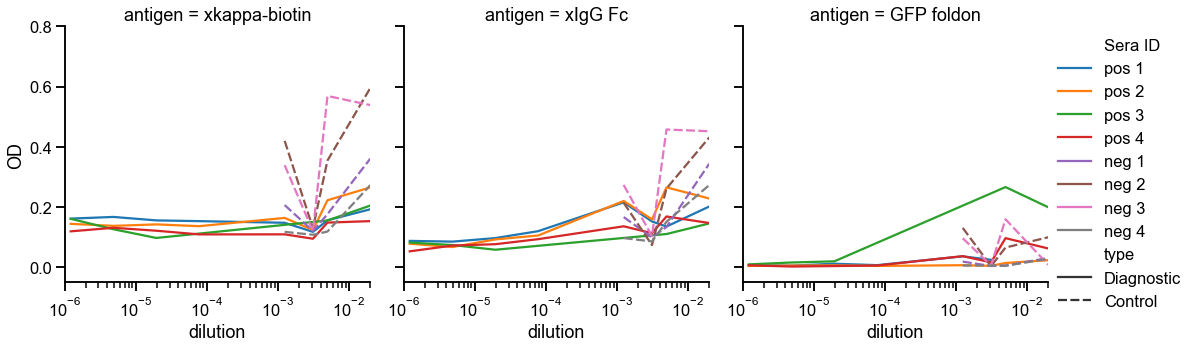

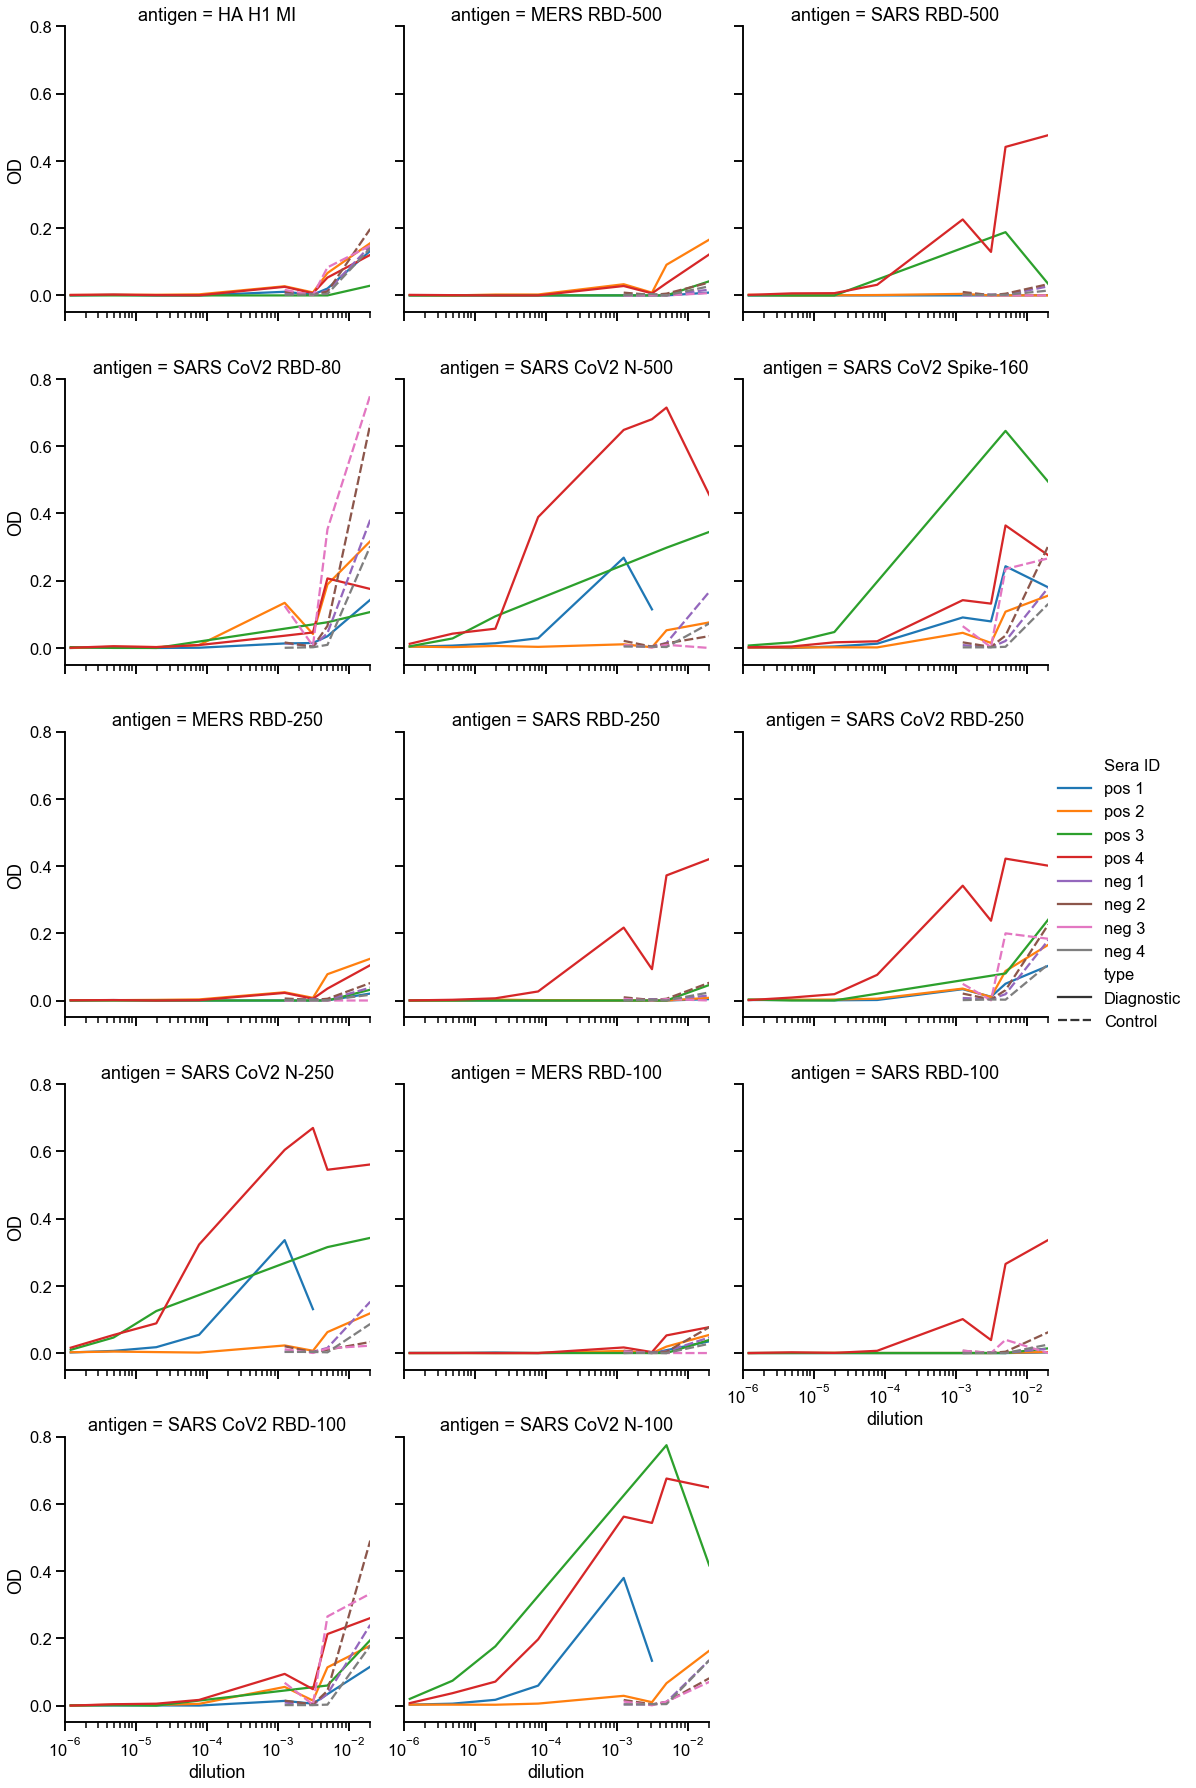

In [168]:
fig_path = os.path.join(data_folder, 'pyseroOD_per_Ag_selectedSera')
os.makedirs(fig_path, exist_ok=True)
pipeline = 'python'
seralist = ['pos 1', 'pos 2', 'pos 3', 'pos 4', 'neg 1', 'neg 2', 'neg 3', 'neg 4'] # All +ve sera are affected by comets at some antigens, first 4 negative sera are not affected by comets.
controlag = ['xkappa-biotin','xIgG Fc', 'GFP foldon']

selectsera_ctlag = python_df_fix[(python_df_fix['Sera ID'].isin(seralist) & python_df_fix['antigen'].isin(controlag))]
selectsera_diagag = python_df_fix[(python_df_fix['Sera ID'].isin(seralist) & ~python_df_fix['antigen'].isin(controlag))]


g = sns.relplot(x="dilution", y="OD",
                    hue="Sera ID", style = "type", col="antigen", ci=None, 
                     data=selectsera_ctlag, col_wrap=3, estimator=np.nanmedian, kind='line')
g.set(xscale="log", ylim=[-0.05, 0.8], xlim=[1E-6, 2E-2])
plt.savefig(os.path.join(fig_path, '_'.join(['pyseroOD_ControlAg' + '.jpg'])), dpi=300, bbox_inches='tight')

g = sns.relplot(x="dilution", y="OD",
                    hue="Sera ID", style = "type", col="antigen", ci=None, 
                     data=selectsera_diagag, col_wrap=3, estimator=np.nanmedian, kind='line')
g.set(xscale="log", ylim=[-0.05, 0.8], xlim=[1E-6, 2E-2])
plt.savefig(os.path.join(fig_path, '_'.join(['pyseroOD_DiagAg' + '.jpg'])), dpi=300, bbox_inches='tight')



## Fit curves to above plots

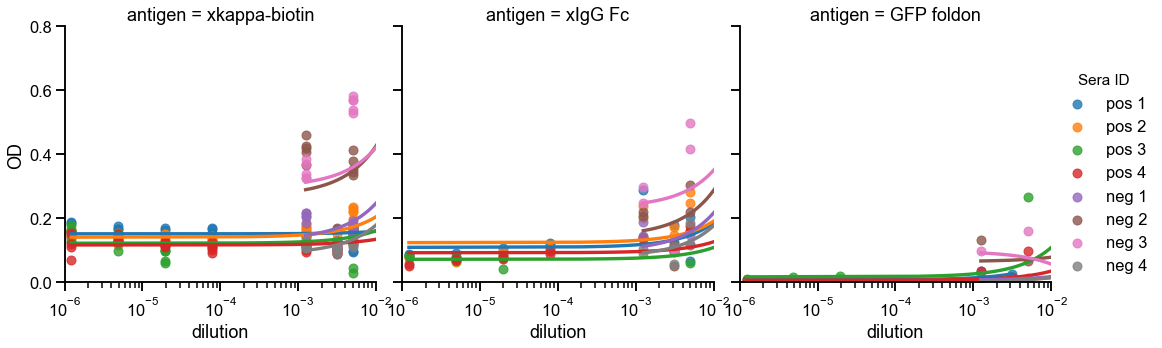

In [164]:
g = sns.lmplot(x="dilution", y="OD", hue="Sera ID", col="antigen", col_wrap=3, data=selectsera_ctlag, ci=None, 
                robust=True, truncate = True)
g.set(xscale="log", ylim=[0,0.8], xlim=[1E-6, 1E-2]);
plt.savefig(os.path.join(fig_path, '_'.join(['pyseroOD_ControlAgFit' + '.jpg'])), dpi=300, bbox_inches='tight')


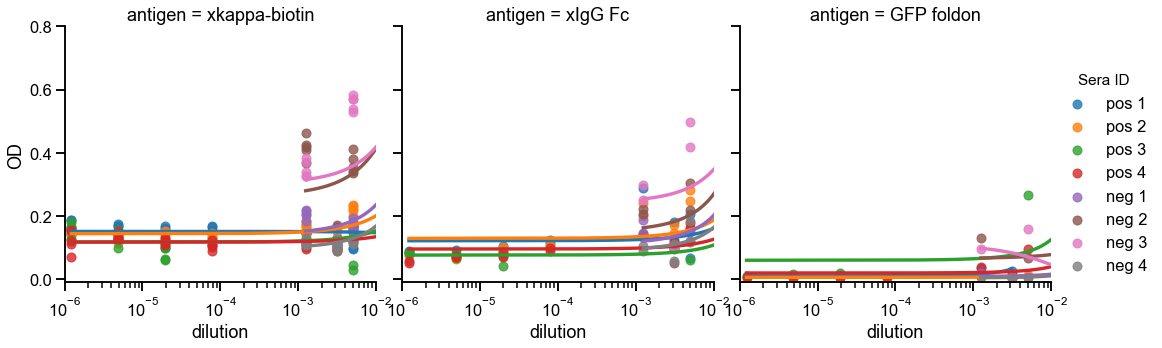

In [162]:
g = sns.lmplot(x="dilution", y="OD", hue="Sera ID", col="antigen", col_wrap=3, data=selectsera_ctlag, ci=None, 
               logistic=True, truncate=True)
g.set(xscale="log", ylim=[-0.01,0.8], xlim=[1E-6, 1E-2]);


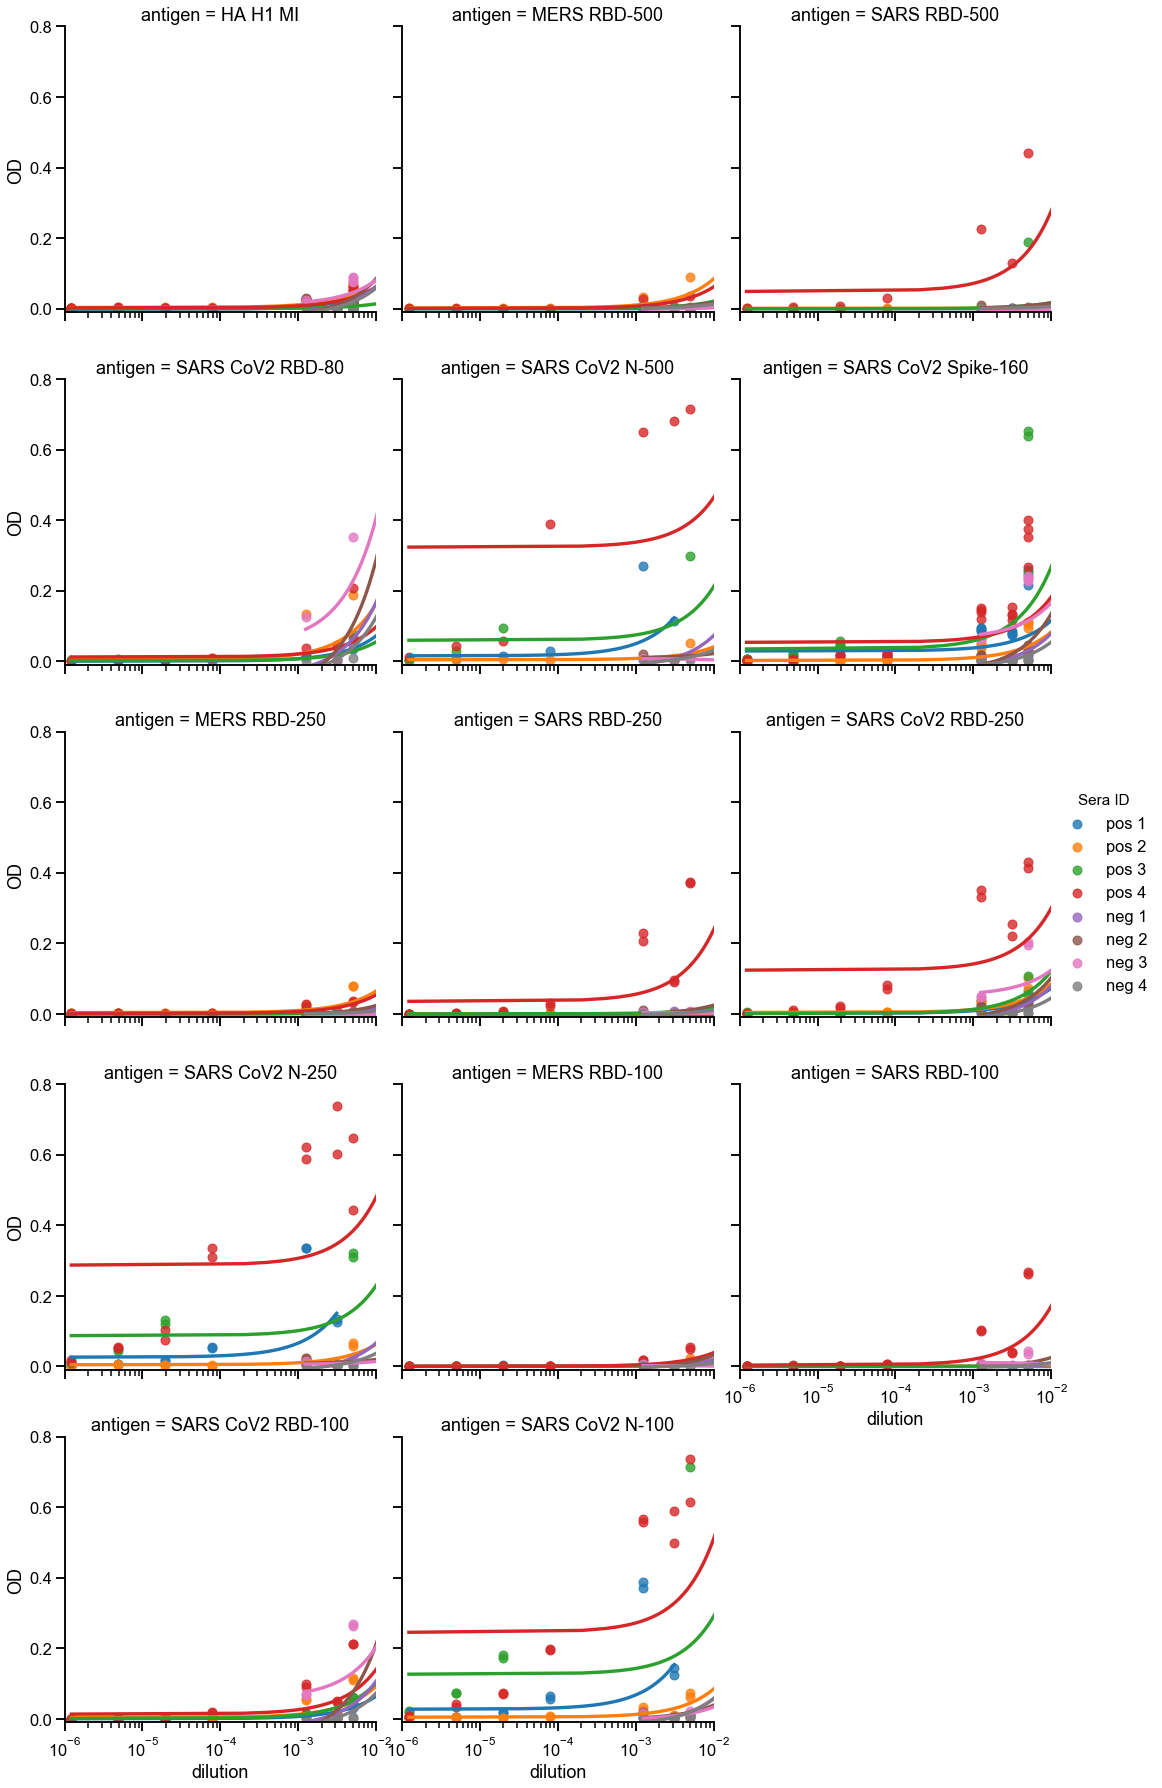

In [166]:
g = sns.lmplot(x="dilution", y="OD", hue="Sera ID", col="antigen", col_wrap=3, data=selectsera_diagag, ci=None, 
                 robust=True, truncate = True)
g.set(xscale="log", ylim=[-0.01,0.8], xlim=[1E-6, 1E-2]);
plt.savefig(os.path.join(fig_path, '_'.join(['pyseroOD_DiagAgFit' + '.jpg'])), dpi=300, bbox_inches='tight')
